<div>
<img align="right" src="pictures/Logo.png" width="200"/>
</div>

# Persistent topological spectra tested on a real device

Kathrin König (kathrin.koenig@iaf.fraunhofer.de), Andreas Woitzik (andreas.woitzik@physik.uni-freiburg.de), Eric Brunner (eric.brunner@physik.uni-freiburg.de)

In [20]:
import numpy as np
import qtda_module as qtda
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import transpile
from qiskit.circuit.library import UnitaryGate
from qiskit_ibm_runtime import SamplerV2 as Sampler

In this notebook we test the quantum algorithm for the persistent topological analysis on real quantum hardware.

In [21]:
service = QiskitRuntimeService()
backend = service.backend(
    "ibm_rensselaer",
    instance="rpi-rensselaer/classes/itws-4940-callab"
)

/tmp/ipykernel_9677/2025127781.py:1: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService()


## Quantum circuit for the topological analysis

As an example, the quantum circuit for the topological analysis of a simplicial complex of three abstract points is used.
<div>
<img src="pictures/Simplex_real-device.png" width="200"/>
</div>

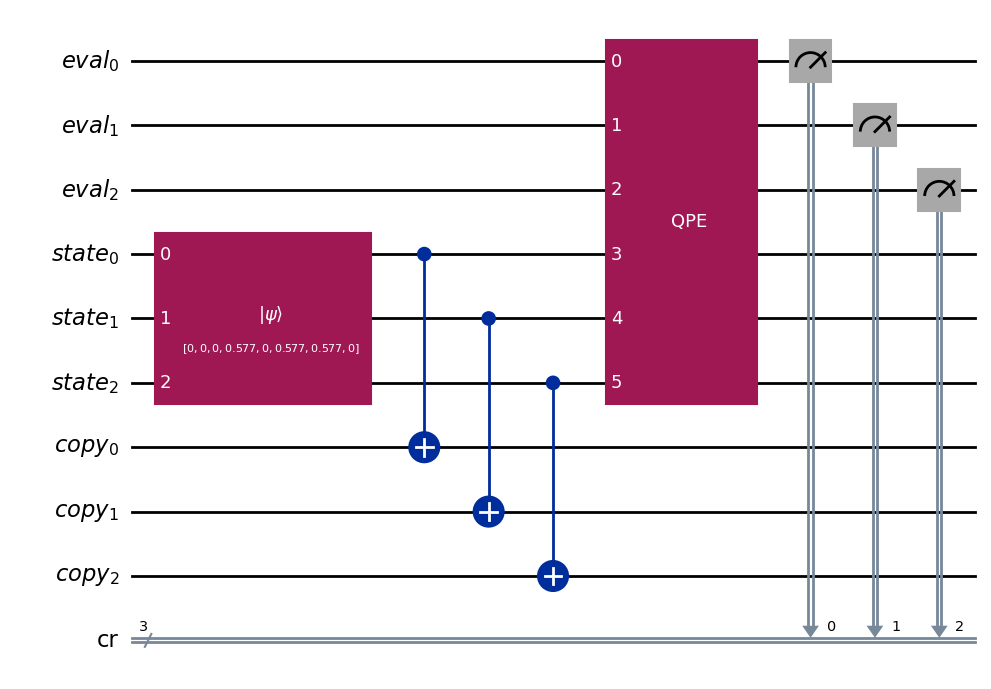

In [22]:
n_vertices = 3 # number of vertices
num_eval_qubits = 3 # number of evaluation qubits

S0 = [(0,0,1),(0,1,0), (1,0,0)] # points
S1 = [(1,0,1),(0,1,1),(1,1,0)] # lines
S2 = []

state_dict = {0: S0, 1: S1, 2: S2}
k = 1 # order of the combinatorial Laplacian
qc = qtda.QTDAalgorithm(num_eval_qubits, k, state_dict)

qc.add_register(ClassicalRegister(num_eval_qubits, name="cr")) # adding a classical register for measuring
for q in qc.eval_qubits: # measure all evaluation qubits
    qc.measure(q,q)
qc.draw('mpl')

The circuit is transpiled to the basis gates set `'id', 'rz', 'sx', 'x' and 'cx'`, with the layout method `sabre` (reduces full routing cost) and optimization level 3 (heavy optimization).
The transpilation is done for an arbitrary backend and the `ibmq_brooklyn`.

In [23]:
qcc = transpile(qc, basis_gates=['id', 'rz', 'sx', 'x', 'cx'], layout_method='sabre',optimization_level=3)

In [24]:
qa = transpile(qc, backend=backend, basis_gates=['id', 'rz', 'sx', 'x', 'cx'],layout_method='sabre',optimization_level=3)

/mnt/c/users/maryc/onedrive/desktop/Quantum Research 2025/.venv/lib/python3.10/site-packages/qiskit/compiler/transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(


For quantum computers in the NISQ era, a high circuit depth amplifies the errors and is undesired. Because of the high circuit depth, we do expect a high noise level.

In [25]:
qa.depth() # depth of ibmq_brooklyn

1198

In [26]:
qcc.depth() # depth of an arbitrary backend

771

We estimate the number of 1-holes from the output counting statics, by adding measurements on the evaluation qubits (listed in qc.eval_qubits). The number of 1-holes, i.e. the first Betti-number $\beta_1$, is equal to the probability of measuring eigenvalue $0$ of $\Delta_1$ (i.e. the phase $\varphi = 0/2\pi = 0$ at the end of the QPE algorithm) times the dimension of the 1-simplex subspace

$$
\beta_1 = \dim \text{Eig}_0 \Delta_1 = | \lbrace s_1^i \rbrace_i | \; \text{Prob} \left( \frac{0}{2\pi} \right) = 3 \; \text{Prob} \left( \frac{0}{2\pi} \right)
$$

In the considered small example, we have three 1-simplices (edges) $S0 = [(1,0,1),(0,1,1),(1,1,0)]$.

In [31]:
shots = 8192
compiled_circuit = transpile(qa, backend)
sampler = Sampler(backend)
sampler.options.default_shots = shots
result = sampler.run([compiled_circuit]).result()           
counts = result[0].data.cr.get_counts()
print("counts: ", counts)

/mnt/c/users/maryc/onedrive/desktop/Quantum Research 2025/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:875: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


counts:  {'000': 768, '101': 1215, '010': 973, '110': 1135, '111': 950, '100': 1415, '011': 958, '001': 778}


The number of 1-holes is 0.28125


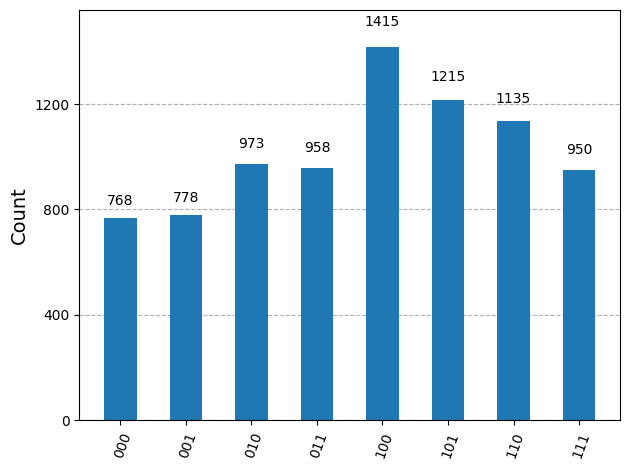

In [32]:
dim = len(state_dict[1]) # dimension of 1-simplex space
prob = counts.get("0"*num_eval_qubits)/shots # probability of eigenvalue 0

print('The number of 1-holes is', dim * prob)
plot_histogram(counts)

We obtain a result of $\sim 0.52$ 1-dimensional holes. Similar results were obtained from several runs of the algorithm on the real quantum hardware. Hence, the number of holes is, unfortunately, not correctly discovered.

As the algorithmon fails to converge with real quantum hardware, a more hardware efficient ansatz needs to be developed. No optimization of the circuit was conducted due to time reasons, but we see a large potential in circuit optimization.

In [29]:
import qiskit
qiskit.__qiskit_version__

AttributeError: module 'qiskit' has no attribute '__qiskit_version__'